(e_raster_reproject)=

----------------

```{admonition} Learning Objectives
- Reproject a raster with rasterio
- Reproject a raster with geowombat

```
```{admonition} Review
* [Affine transformation](d_affine.md)
* [Raster Coordinate Reference Systems](d_raster_crs_intro.md)
```
----------------

# Reproject Rasters w. Rasterio and Geowombat


## Reprojecting a Raster with Geowombat
Far and away the easiest way to handle raster data is by using [geowombat](https://geowombat.readthedocs.io/en/latest/index.html). Here's an example of quickly and easily reprojecting a three band landsat image, and writing it to disk.

In order to reproject on the fly we are going to open the raster using `gw.config.update()`.  The configuration manager allows easy control over opened raster dimensions, alignment, and transformations. All we need to do is pass a `ref_crs` to the configuration manager. We can also use the `resampling` method when we `open` the image, by default it will be `nearest`, but you can also choose one of [‘average’, ‘bilinear’, ‘cubic’, ‘cubic_spline’, ‘gauss’, ‘lanczos’, ‘max’, ‘med’, ‘min’, ‘mode’, ‘nearest’].

In [1]:
import geowombat as gw

proj4 = "+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"
image = "../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

with gw.config.update(ref_crs=proj4):
    with gw.open(image, resampling="nearest") as src:
    
        src.gw.to_raster(
            "../temp/LC08_20200518_aea.tif",
            verbose=0,
            n_workers=4,  # number of process workers 
            n_threads=2,  # number of thread workers ``dask.compute``
            overwrite=True,
        ) 

  0%|                                                                                                           | 0/130 [00:00<?, ?it/s]

  8%|███████▌                                                                                          | 10/130 [00:00<00:01, 98.64it/s]

 27%|██████████████████████████                                                                       | 35/130 [00:00<00:00, 182.67it/s]

 42%|████████████████████████████████████████▎                                                        | 54/130 [00:00<00:00, 161.98it/s]

 55%|████████████████████████████████████████████████████▉                                            | 71/130 [00:00<00:00, 137.27it/s]

 66%|████████████████████████████████████████████████████████████████▏                                | 86/130 [00:00<00:00, 129.00it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▌                  | 105/130 [00:00<00:00, 140.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 157.59it/s]

Let's take a look, remember from earlier that this image is stored as green, blue, red (rather than red, green, blue), so we will use `.sel(band=[3,2,1])` to put them back in the right order.

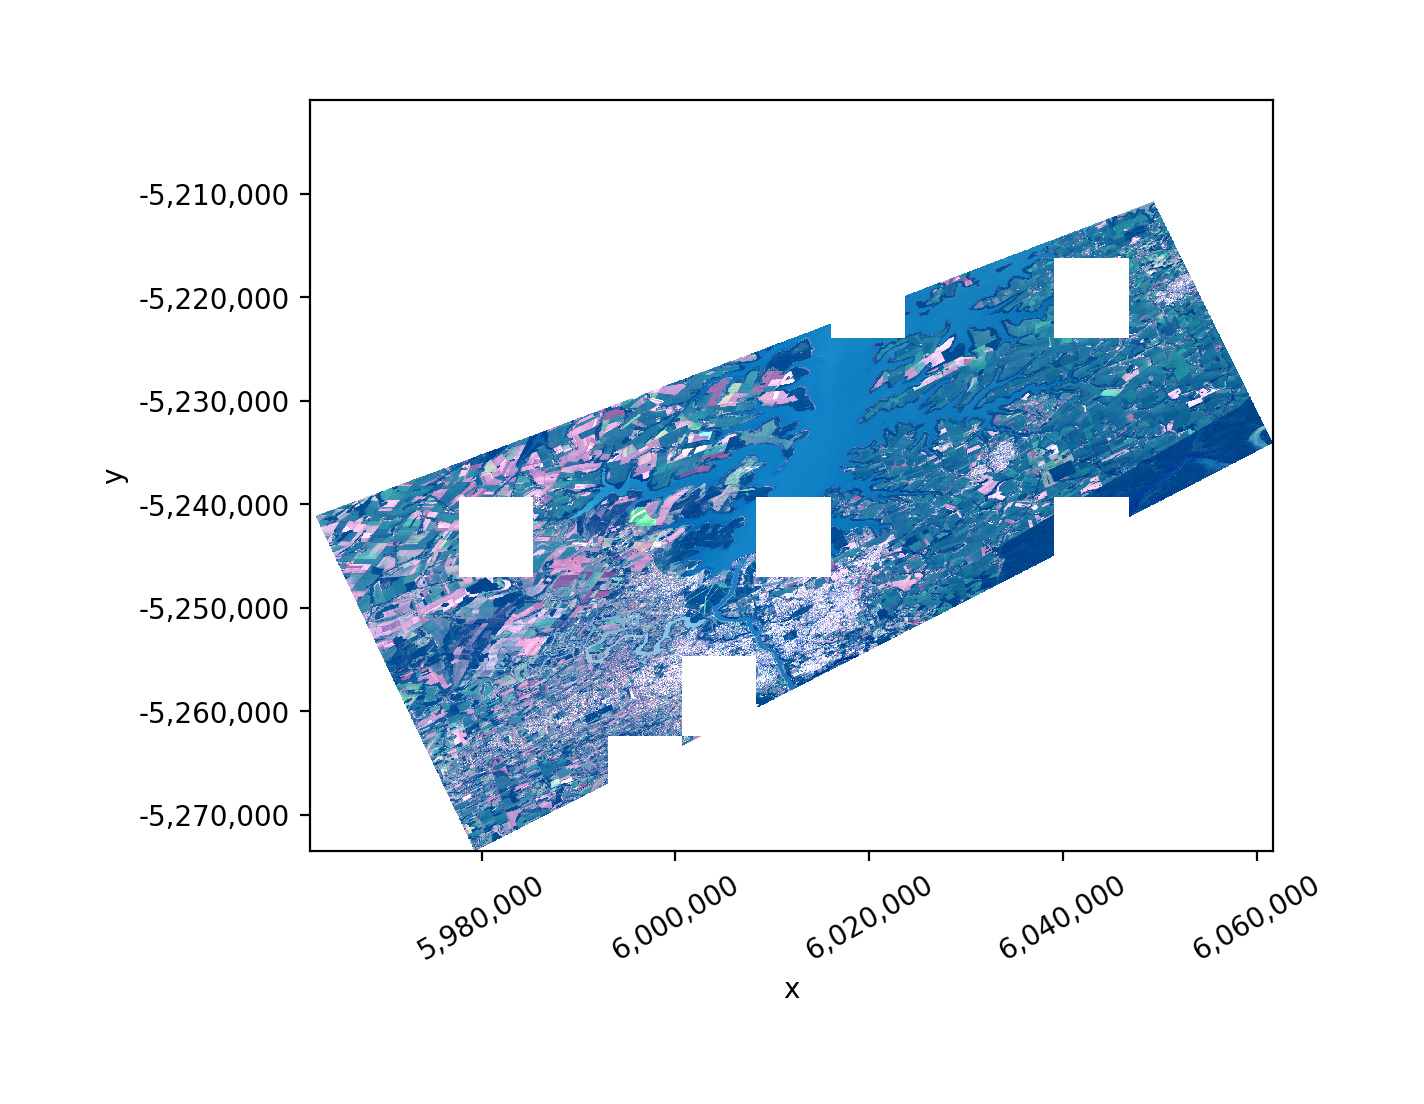

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=200)

image = "../temp/LC08_20200518_aea.tif"
with gw.open(image) as src:
    src.where(src != 0).sel(band=[3, 2, 1]).gw.imshow(robust=True, ax=ax)
    plt.tight_layout(pad=1)


Too easy? Want something more complex? Try the same thing with Rasterio. Yes, there will be a little matrix algebra. 

## Calculate_default_transform Explained

How do we reproject a raster? Before we get into it, we need to talk some more... about `calculate_default_transform`. `calculate_default_transform` allows us to generate the transform matrix required for the new reprojected raster based on the characteristics of the original and the desired output CRS. Note that the `source` (src) is the original input raster, and the `destination` (dst) is the outputed reprojected raster. 

First, remember that the transform matrix takes the following form ([review affine transforms here](d_affine.md)):

$$
    \mbox{Transform} =  \begin{bmatrix} xres & 0 & \Delta x \\ 0 & yres & \Delta y \\ 0 & 0 & 1 \end{bmatrix} 
$$

Now let's calculate the tranform matrix for the destination raster:

In [3]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform

dst_crs = "EPSG:3857"  # web mercator(ie google maps)

with rasterio.open("../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF") as src:

    # transform for input raster
    src_transform = src.transform

    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,    # source CRS
        dst_crs,    # destination CRS
        src.width,    # column count
        src.height,  # row count
        *src.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )

print("Source Transform:\n",src_transform,'\n')
print("Destination Transform:\n", dst_transform)

Source Transform:
 | 30.00, 0.00, 717345.00|
| 0.00,-30.00,-2776995.00|
| 0.00, 0.00, 1.00| 

Destination Transform:
 | 33.24, 0.00,-6105300.09|
| 0.00,-33.24,-2885952.71|
| 0.00, 0.00, 1.00|


Notice that in order to keep the same number of rows and columns that the resolution of the destination raster increased from 30 meters to 33.24 meters. Also the coordinates of the upper left hand corner have shifted (check $\Delta x, \Delta x$).

## Reprojecting a Raster with Rasterio 

Ok finally!

In [4]:
dst_crs = "EPSG:3857"  # web mercator(ie google maps)

with rasterio.open("../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF") as src:
    src_transform = src.transform

    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,
        dst_crs,
        src.width,
        src.height,
        *src.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )

    # set properties for output
    dst_kwargs = src.meta.copy()
    dst_kwargs.update(
        {
            "crs": dst_crs,
            "transform": dst_transform,
            "width": width,
            "height": height,
            "nodata": 0,  # replace 0 with np.nan
        }
    )

    with rasterio.open("../temp/LC08_20200518_webMC.tif", "w", **dst_kwargs) as dst:
        # iterate through bands
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )

```{figure} ../_static/d_crs/d_reproj_image.png
:name: Reprojected Landsat Image
:width: 400px
Reprojected Landsat Image
```